In [1]:
from IPython.display import FileLink

FileLink("MNIST_learned_kernels_8x9x9.pt")

/Users/kelseylee/VS_Code_Projects/comp_metalens/MNIST_learned_kernels_8x9x9.pt

torch.Size([8, 9, 9])


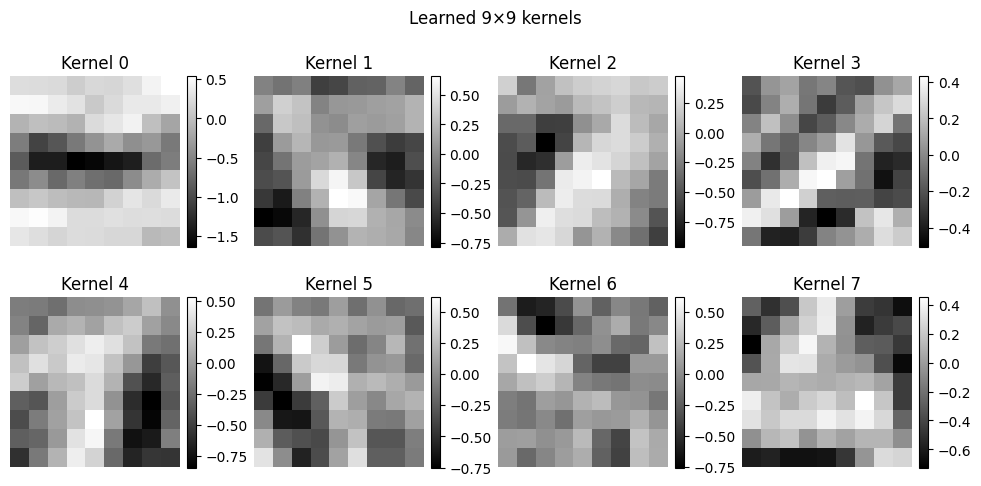

In [3]:
import torch
import matplotlib.pyplot as plt

kernels = torch.load("MNIST_learned_kernels_8x9x9.pt", map_location="cpu")
kernels = kernels.squeeze(1)

print(kernels.shape)

K = kernels.shape[0]  # should be 8

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
fig.suptitle("Learned 9×9 kernels")

for i, ax in enumerate(axes.flat):
    im = ax.imshow(kernels[i], cmap="gray")
    ax.set_title(f"Kernel {i}")
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


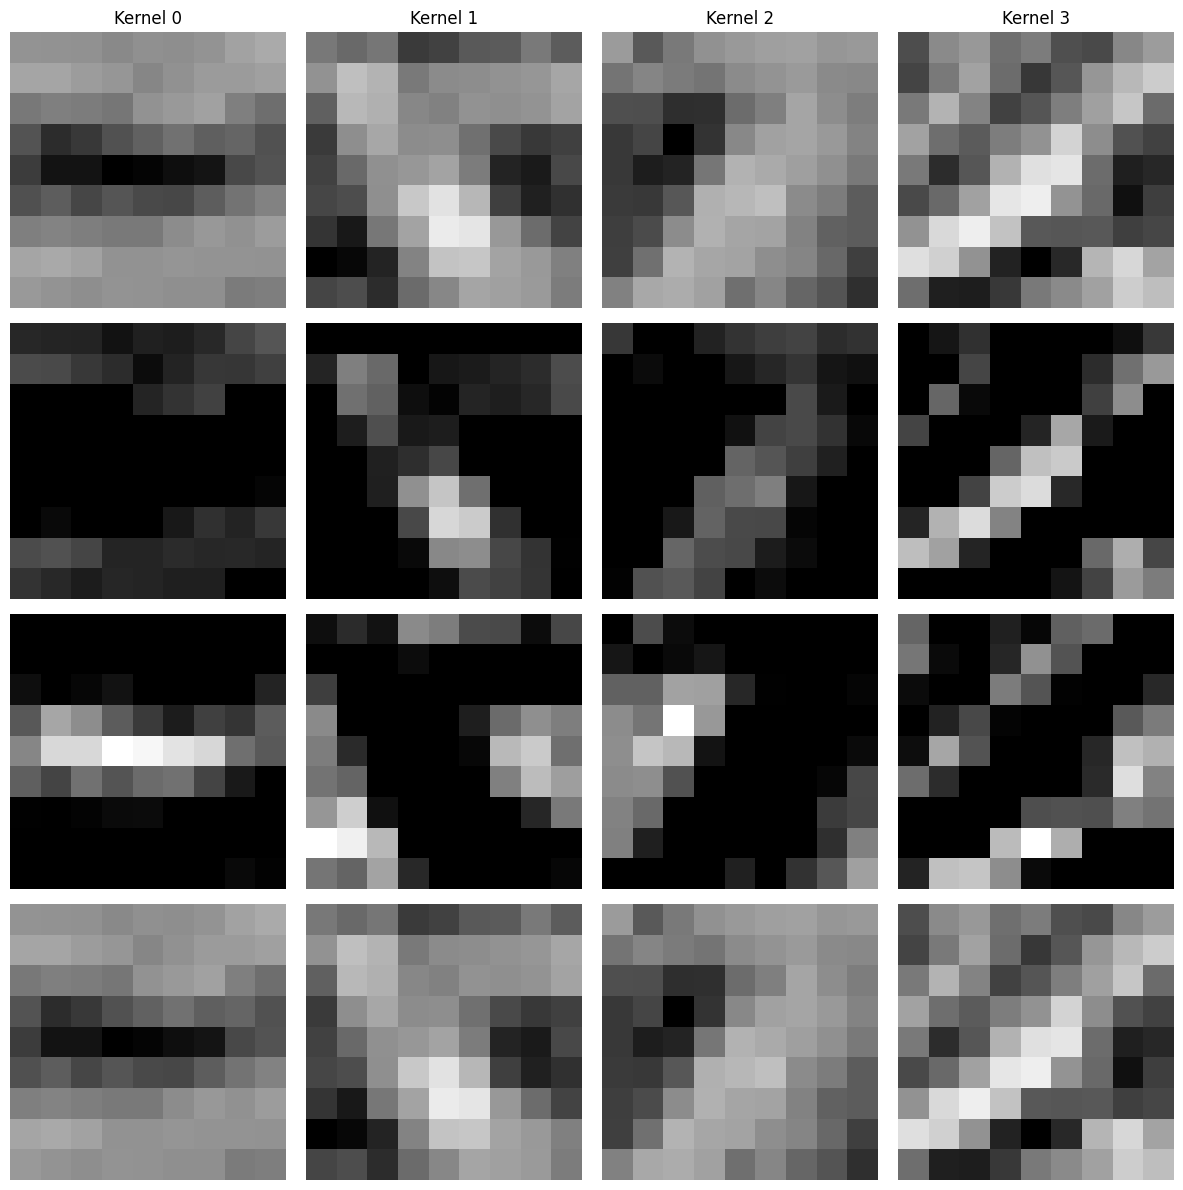

In [4]:
kernel_pos  = torch.clamp(kernels, min=0.0)
kernel_neg  = torch.clamp(-kernels, min=0.0)
kernel_diff = kernel_pos - kernel_neg

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
row_titles = ["Kernel", "Positive part", "Negative part", "Pos − Neg"]

for row in range(4):
    axes[row][0].set_ylabel(row_titles[row], fontsize=12)

for col in range(4):  # show kernels 0–3
    vmax = kernels[col].abs().max()

    im = axes[0][col].imshow(kernels[col], cmap="gray",
                             vmin=-vmax, vmax=vmax)
    axes[0][col].set_title(f"Kernel {col}")
    axes[0][col].axis("off")

    axes[1][col].imshow(kernel_pos[col], cmap="gray",
                         vmin=0, vmax=vmax)
    axes[1][col].axis("off")

    axes[2][col].imshow(kernel_neg[col], cmap="gray",
                         vmin=0, vmax=vmax)
    axes[2][col].axis("off")

    axes[3][col].imshow(kernel_diff[col], cmap="gray",
                         vmin=-vmax, vmax=vmax)
    axes[3][col].axis("off")

plt.tight_layout()
plt.show()


In [6]:
raw_kernels = torch.empty((16, 9, 9), dtype=kernels.dtype, device=kernels.device)

raw_kernels[0::2] = kernel_pos
raw_kernels[1::2] = kernel_neg

print("raw psf kernels shape:", raw_kernels.shape)

raw psf kernels shape: torch.Size([16, 9, 9])


In [7]:
import torch

def upsample_and_center_kernels(raw_kernels: torch.Tensor, upsample: int, grid_N: int) -> torch.Tensor:
    """
    raw_kernels: (M, N, N) tensor (e.g., 16x7x7)
    upsample: integer scale factor (e.g., 2 -> each pixel becomes 2x2, so 7x7 -> 14x14)
    grid_N: output grid size (e.g., 255 -> output is 16x255x255)

    Returns:
        centered: (M, grid_N, grid_N) tensor where the upsampled kernel is centered and
                  the rest is zero-padded.
    """
    if raw_kernels.ndim != 3:
        raise ValueError(f"raw_kernels must be (M,N,N). Got shape {tuple(raw_kernels.shape)}")
    if upsample < 1 or not isinstance(upsample, int):
        raise ValueError(f"upsample must be a positive int. Got {upsample}")
    if not isinstance(grid_N, int) or grid_N < 1:
        raise ValueError(f"grid_N must be a positive int. Got {grid_N}")

    M, N1, N2 = raw_kernels.shape
    if N1 != N2:
        raise ValueError(f"raw_kernels must be square in the last two dims. Got {N1}x{N2}")

    # Nearest-neighbor "pixel replication": each pixel -> (upsample x upsample) block
    up = raw_kernels.repeat_interleave(upsample, dim=1).repeat_interleave(upsample, dim=2)  # (M, N*upsample, N*upsample)

    Ku = up.shape[-1]
    if Ku > grid_N:
        raise ValueError(f"Upsampled kernel is {Ku}x{Ku}, which is larger than grid_N={grid_N}")

    # Create output and center-insert
    centered = torch.zeros((M, grid_N, grid_N), dtype=raw_kernels.dtype, device=raw_kernels.device)

    # Center placement (works for odd/even sizes)
    start = (grid_N - Ku) // 2
    end = start + Ku
    centered[:, start:end, start:end] = up

    return centered


In [8]:
# raw_kernels: (16, 7, 7)
kernels_grid = upsample_and_center_kernels(raw_kernels, upsample=4, grid_N=255)
print(kernels_grid.shape)  # (16, 255, 255)


torch.Size([16, 255, 255])


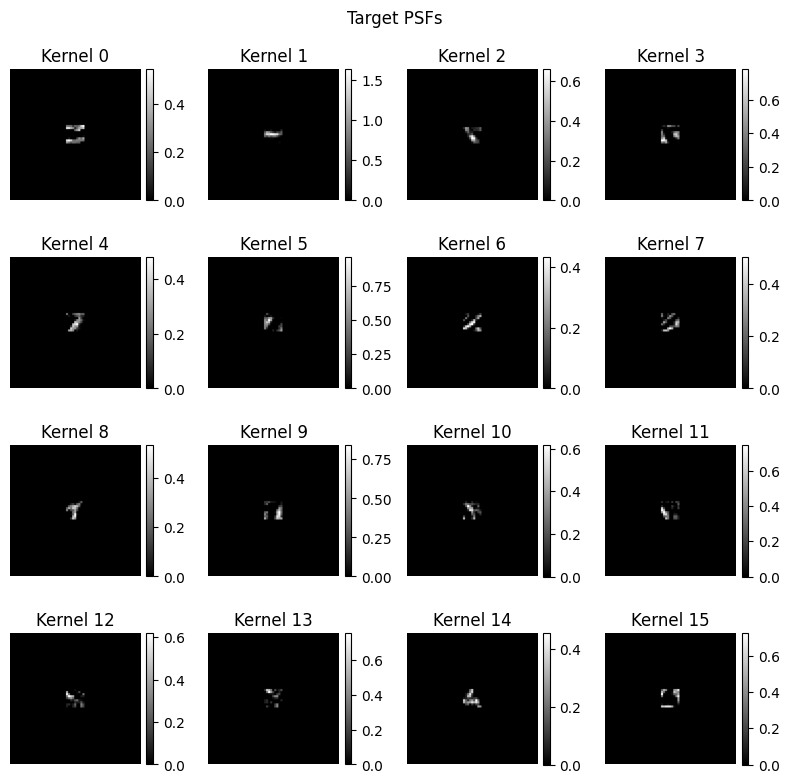

In [12]:
import matplotlib.pyplot as plt

# # Indices of the first 4 positive kernels
# pos_indices = [0, 2, 4, 6]

# fig, axes = plt.subplots(1, 4, figsize=(12, 3))
# fig.suptitle("First 4 positive kernels (upsampled + centered)")

# for ax, idx in zip(axes, pos_indices):
#     im = ax.imshow(kernels_grid[idx], cmap="gray")
#     ax.set_title(f"Kernel {idx} (pos)")
#     ax.axis("off")
#     plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# plt.tight_layout()
# plt.show()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle("Target PSFs")

for i in range(16):
    ax = axes[i//4, i%4]
    im = ax.imshow(kernels_grid[i], cmap="gray")
    ax.set_title(f"Kernel {i}")
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


Loaded batch: torch.Size([10, 28, 28])
Labels (first 10): [3, 1, 1, 0, 4, 9, 2, 0, 0, 2]


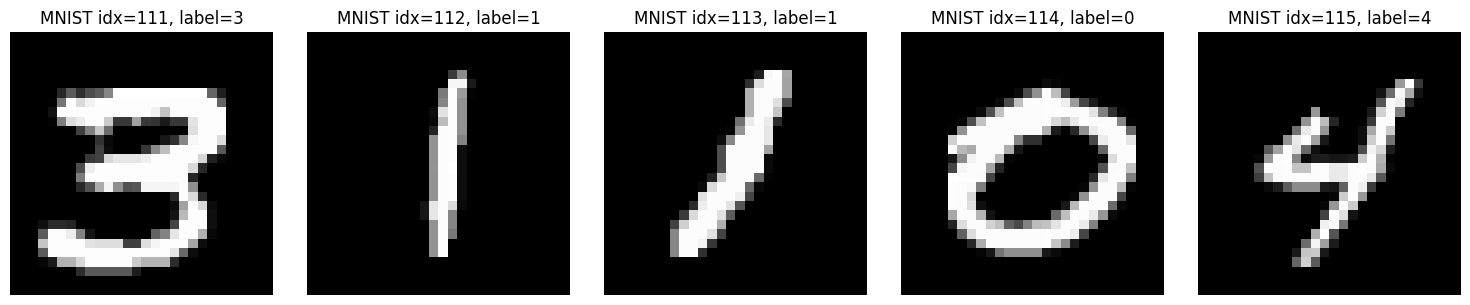

In [8]:
import torch
from torchvision.datasets import MNIST
import numpy as np

# Load MNIST from your existing ./data folder (no download)
ds = MNIST(root="./data", train=True, download=False)

# Choose how many images to batch
N_batch = 10
idx0 = 111   # starting index

# Stack N_batch images into a batch
objs = []
labels = []
for i in range(N_batch):
    x_pil, y = ds[idx0 + i]
    objs.append(torch.from_numpy(np.array(x_pil)).float() / 255.0)
    labels.append(y)

objs = torch.stack(objs, dim=0)   # [N,28,28]

print("Loaded batch:", objs.shape)
print("Labels (first 10):", labels[:10])

num_show = 5

fig, axes = plt.subplots(1, num_show, figsize=(3 * num_show, 3))

for i in range(num_show):
    ax = axes[i]
    ax.imshow(objs[i], cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"MNIST idx={idx0+i}, label={labels[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


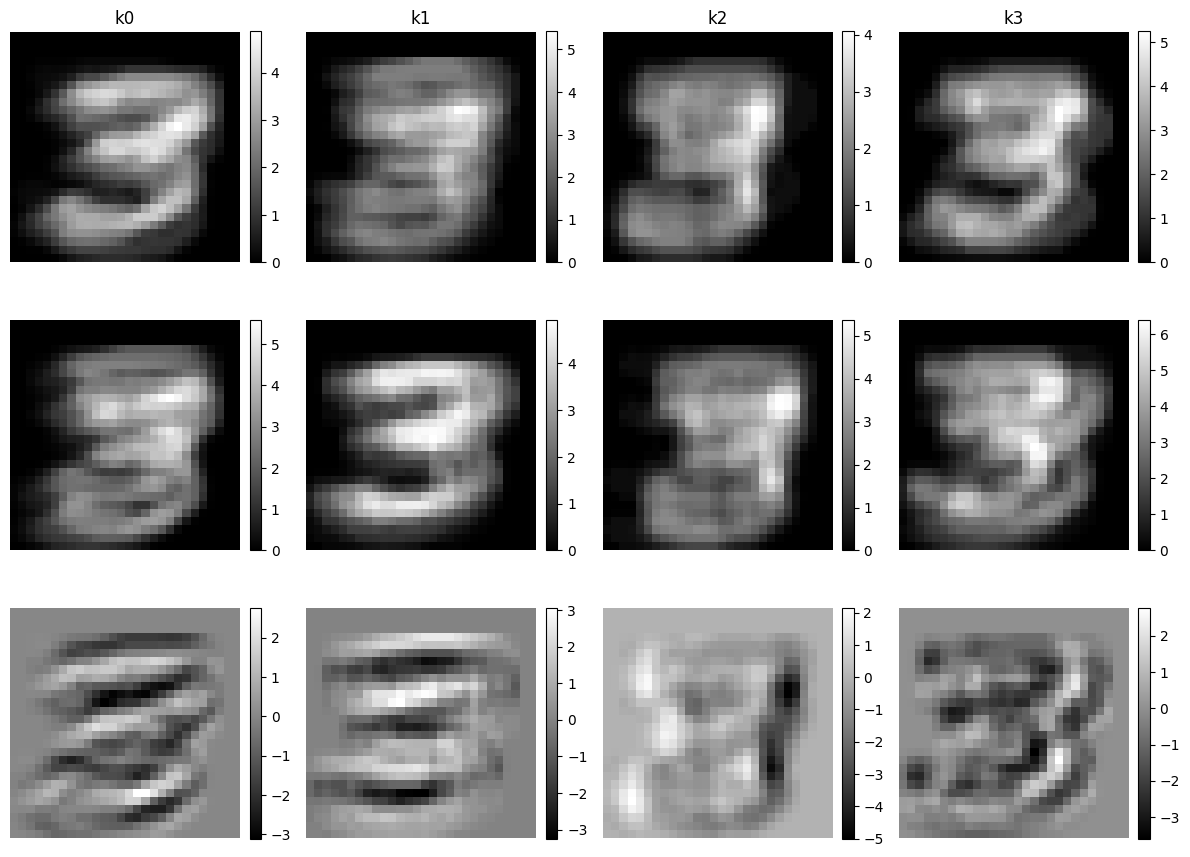

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- pick the first MNIST image and make it (1,1,H,W) ----
img0 = objs[0]
if isinstance(img0, torch.Tensor):
    img0_t = img0
else:
    img0_t = torch.tensor(img0)

if img0_t.ndim == 2:          # (H, W)
    img0_t = img0_t.unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
elif img0_t.ndim == 3:        # (1,H,W) or (C,H,W)
    img0_t = img0_t.unsqueeze(0)               # (1,C,H,W)
else:
    raise ValueError(f"Unexpected objs[0] shape: {img0_t.shape}")

img0_t = img0_t.float()

device = img0_t.device
kernel_pos  = kernel_pos.to(device).float()
kernel_neg  = kernel_neg.to(device).float()
kernel_diff = kernel_diff.to(device).float()

# ---- build conv weight banks for first 4 kernels ----
w_pos  = kernel_pos[:4].unsqueeze(1)   # (4,1,7,7)
w_neg  = kernel_neg[:4].unsqueeze(1)   # (4,1,7,7)
w_diff = kernel_diff[:4].unsqueeze(1)  # (4,1,7,7)

pad = w_pos.shape[-1] // 2  # 7 -> 3

# ---- convolve (output: (1,4,H,W)) ----
y_pos  = F.conv2d(img0_t, w_pos,  padding=pad)
y_neg  = F.conv2d(img0_t, w_neg,  padding=pad)
y_diff = F.conv2d(img0_t, w_diff, padding=pad)

# ---- plot: 3 rows (pos/neg/diff) x 4 cols (kernels 0..3) ----
outputs = [y_pos, y_neg, y_diff]
row_names = ["kernel_pos", "kernel_neg", "kernel_diff"]

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for r in range(3):
    for c in range(4):
        ax = axes[r, c]
        img = outputs[r][0, c].detach().cpu()
        im = ax.imshow(img, cmap="gray")
        ax.axis("off")
        if r == 0:
            ax.set_title(f"k{c}")
        if c == 0:
            ax.set_ylabel(row_names[r], rotation=90, fontsize=11)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [10]:
import math

import sys
sys.path.append("asm_full_opt")
from phase_mask import PhaseMask
from asm_prop import ASMPropagator
from pixel_map import PixelMap
from psf_conv import PSFConv
import config

all_imgs: torch.Size([16, 1, 1, 255, 255])


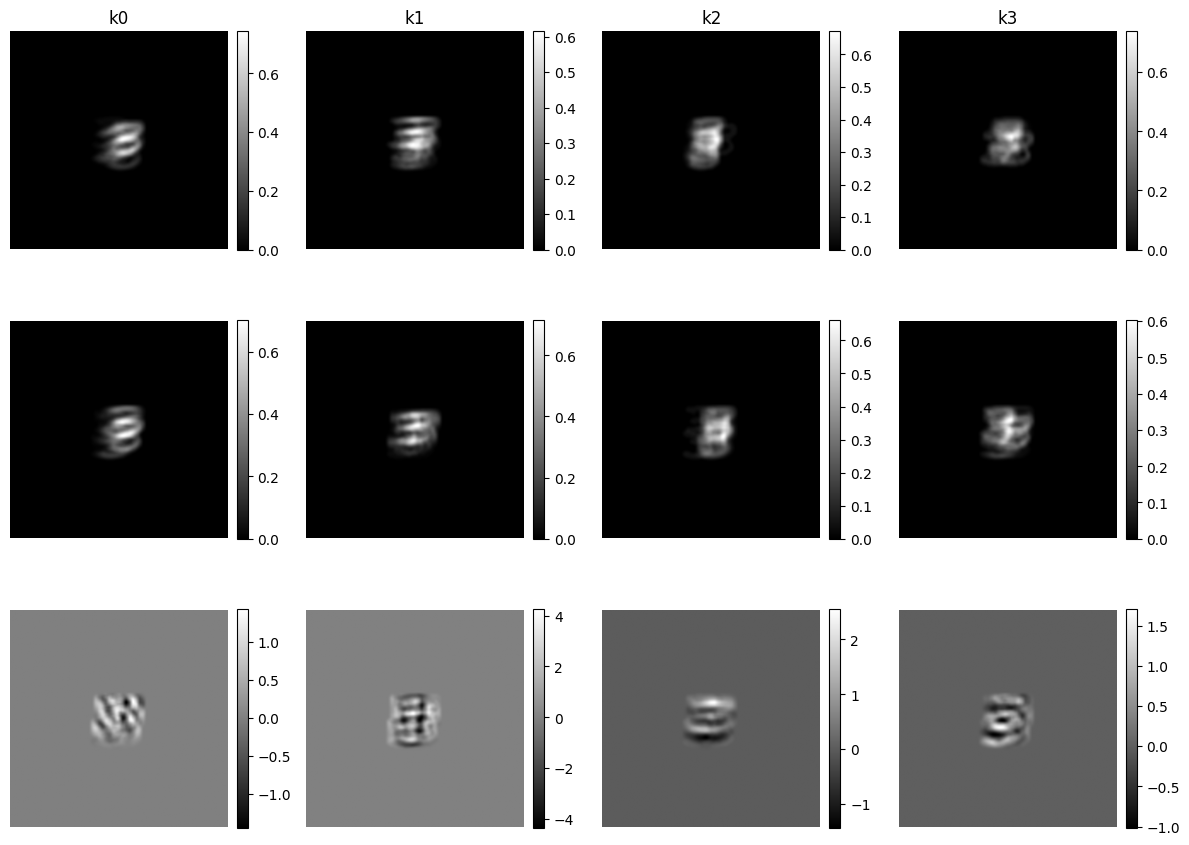

In [11]:
asm = ASMPropagator(config)
pm = PixelMap(config, asm.X, asm.Y)
conv = PSFConv(config, pm, asm.X, asm.Y)


all_imgs = []
for i in range(kernels_grid.shape[0]):  # 16
    psf = kernels_grid[i].T.flip(1)
    img = conv.sensor_image(objs[0], psf)         # (1,1,255,255)
    all_imgs.append(img)

all_imgs = torch.stack(all_imgs, dim=0)           # (16,1,1,255,255)
print("all_imgs:", all_imgs.shape)

# ------------------ Indices ------------------ #
pos_idx = [0, 2, 4, 6]
neg_idx = [1, 3, 5, 7]

# Stored pos/neg outputs
imgs_pos = all_imgs[pos_idx]                      # (4,1,1,255,255)
imgs_neg = all_imgs[neg_idx]                      # (4,1,1,255,255)

# "Difference" row: run sensor_image on a difference PSF (robust if sensor_image isn't linear)
imgs_diff = []
for p, n in zip(pos_idx, neg_idx):
    psf_diff = kernels_grid[p] - kernels_grid[n]  # (255,255)
    imgs_diff.append(conv.sensor_image(objs[0], psf_diff))  # (1,1,255,255)
imgs_diff = torch.stack(imgs_diff, dim=0)         # (4,1,1,255,255)

# ------------------ Plot: 3 rows x 4 cols ------------------ #
rows = [imgs_pos, imgs_neg, imgs_diff]
row_names = ["pos", "neg", "diff (pos - neg)"]

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for r in range(3):
    for c in range(4):
        ax = axes[r, c]
        img2d = rows[r][c, 0, 0].detach().cpu()    # -> (255,255)
        img2d = img2d.T.flip(0).flip(1)

        im = ax.imshow(img2d, cmap="gray", origin="lower")
        ax.axis("off")

        if r == 0:
            ax.set_title(f"k{c}")
        if c == 0:
            ax.set_ylabel(row_names[r], rotation=90, fontsize=11)

        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()





torch.Size([16, 14, 14])


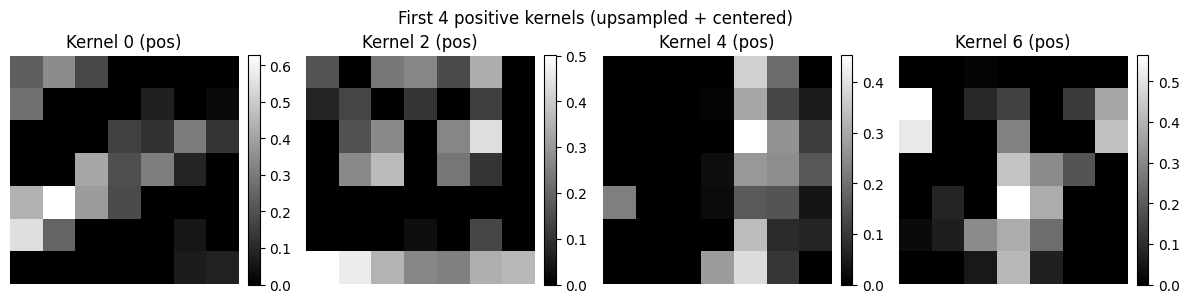

In [12]:
# raw_kernels: (16, 7, 7)
kernels_grid1 = upsample_and_center_kernels(raw_kernels, upsample=2, grid_N=14)
print(kernels_grid1.shape)  # (16, 255, 255)

# Indices of the first 4 positive kernels
pos_indices = [0, 2, 4, 6]

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
fig.suptitle("First 4 positive kernels (upsampled + centered)")

for ax, idx in zip(axes, pos_indices):
    im = ax.imshow(kernels_grid1[idx], cmap="gray")
    ax.set_title(f"Kernel {idx} (pos)")
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [21]:
import torch

# kernels_grid1: (16, 14, 14)
# We assume current order is interleaved: [pos0, neg0, pos1, neg1, ..., pos7, neg7]

def rearrange_posneg_blocks(kernels_grid1: torch.Tensor) -> torch.Tensor:
    if kernels_grid1.ndim != 3 or kernels_grid1.shape[0] != 16:
        raise ValueError(f"Expected (16, H, W). Got {tuple(kernels_grid1.shape)}")

    order = [
        15, 13, 11,  9,
        14, 12, 10,  8,
         7,  5,  3,  1,
         6,  4,  2,  0,
    ]

    out = kernels_grid1[order]
    return out

def stitch_4x4_with_spacing(kernels_16: torch.Tensor, tile_N: int = 14, gap: int = 10) -> torch.Tensor:
    """
    kernels_16: (16, tile_N, tile_N)
    Returns stitched image of shape (H_stitch, W_stitch) where
    H_stitch = 4*tile_N + 3*gap and same for width.
    """
    if kernels_16.ndim != 3 or kernels_16.shape[0] != 16:
        raise ValueError(f"Expected (16, tile_N, tile_N). Got {tuple(kernels_16.shape)}")
    if kernels_16.shape[1] != tile_N or kernels_16.shape[2] != tile_N:
        raise ValueError(f"Expected tiles of {tile_N}x{tile_N}. Got {kernels_16.shape[1]}x{kernels_16.shape[2]}")

    H = 4 * tile_N + 3 * gap
    W = 4 * tile_N + 3 * gap
    stitched = torch.zeros((H, W), dtype=kernels_16.dtype, device=kernels_16.device)

    for r in range(4):
        for c in range(4):
            idx = r * 4 + c
            y0 = r * (tile_N + gap)
            x0 = c * (tile_N + gap)
            stitched[y0:y0+tile_N, x0:x0+tile_N] = kernels_16[idx]

    return stitched

def center_in_grid(img: torch.Tensor, grid_N: int = 255) -> torch.Tensor:
    """
    img: (H, W)
    Returns: (grid_N, grid_N) with img centered.
    """
    if img.ndim != 2:
        raise ValueError(f"Expected (H,W). Got {tuple(img.shape)}")
    H, W = img.shape
    if H > grid_N or W > grid_N:
        raise ValueError(f"Image {H}x{W} larger than grid {grid_N}x{grid_N}")

    out = torch.zeros((grid_N, grid_N), dtype=img.dtype, device=img.device)
    y0 = (grid_N - H) // 2
    x0 = (grid_N - W) // 2
    out[y0:y0+H, x0:x0+W] = img
    return out

# --------- Run your pipeline ---------
kernels_reordered = rearrange_posneg_blocks(kernels_grid1)                 # (16,14,14)
stitched_86 = stitch_4x4_with_spacing(kernels_reordered, tile_N=14, gap=42) # (86,86)
stitched_255 = center_in_grid(stitched_86, grid_N=255)                      # (255,255)

print("kernels_reordered:", kernels_reordered.shape)
print("stitched_86:", stitched_86.shape)
print("stitched_255:", stitched_255.shape)


kernels_reordered: torch.Size([16, 14, 14])
stitched_86: torch.Size([182, 182])
stitched_255: torch.Size([255, 255])


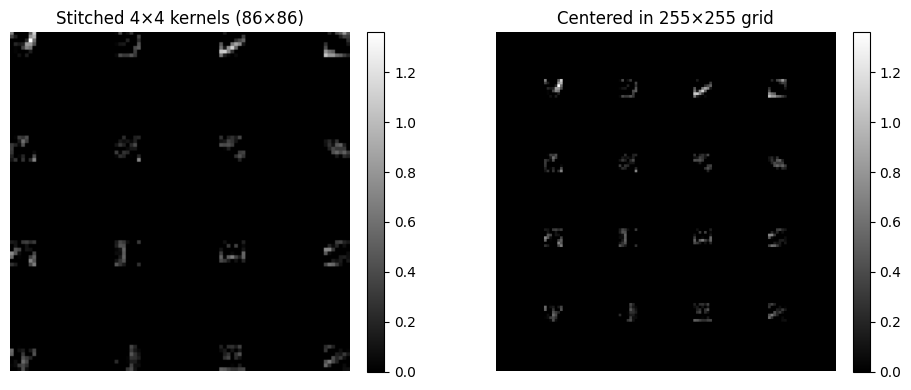

In [22]:
import matplotlib.pyplot as plt

# stitched_86: (86, 86)
# stitched_255: (255, 255)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- stitched 86x86 ---
im0 = axes[0].imshow(stitched_86, cmap="gray")
axes[0].set_title("Stitched 4×4 kernels (86×86)")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# --- stitched centered in 255x255 ---
im1 = axes[1].imshow(stitched_255, cmap="gray")
axes[1].set_title("Centered in 255×255 grid")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


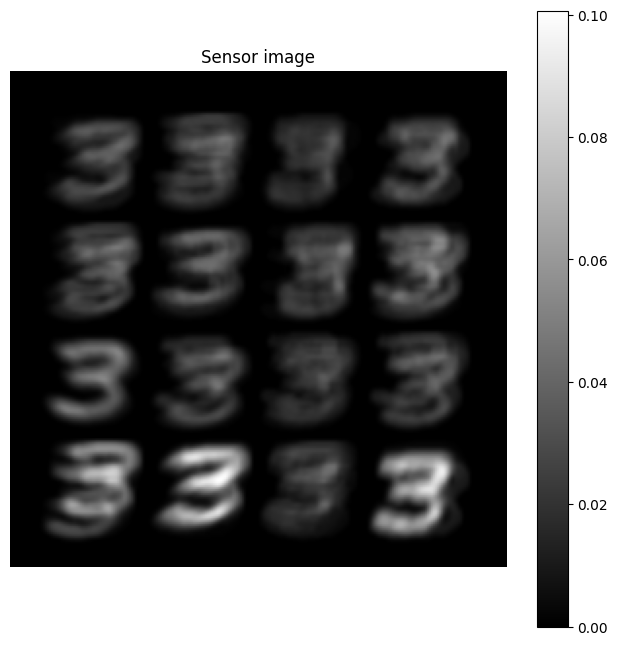

In [26]:
psf1 = stitched_255.T.flip(1)

img = conv.sensor_image(objs[0], psf1) 

img2d = img[0, 0]

plt.figure(figsize=(8, 8))
plt.imshow(img2d.T.flip(0).flip(1), cmap="gray", origin="lower")
plt.title("Sensor image")
plt.axis("off")
plt.colorbar()
plt.show()